<img src="https://legalhackers19.s3.amazonaws.com/Mind+Map.png">

# Legal Hackers Annual Summit 2019
## Open Legal Data Forum

<img src="https://legalhackers19.s3.amazonaws.com/CAP_image.png">

The amassed body of the decisions of judges in the courts serves as an unwitting commentary on how far we have come (or, in some cases, how far we have yet to develop) as civilised societies governed by the rule of law. Case law is jam-packed with hidden insight just waiting to be uncovered. It can tell us how certain issues have risen to prominence and descended back into irrelevance over time. It can provide us with clues about how the occurrence of specific criminal offences relate to broader issues in taking place in society. It can show us how far societal attitudes have evolved in any number of walks of life.

What is strange is that, until very recently, openly accessible case law data was virtually non-existent; the material could only be accessed on a document-by-document basis via expensive subscription services traditionally used by lawyers that, one way or another, prohibited “big data” research at scale. 

The launch of the Case Law Access Project (CAP) by the Library Innovation Lab at Harvard University in 2018 was a significant leap forward for open legal data research: CAP exposes a mega 6.7 million US state decisions and 1.7 million federal decisions in a semi-structured format. 

The CAP dataset provides the potential for a dizzying array of innovative applications, but it also presents us, as researchers, with a range of technical challenges bound up with wrangling and exploring such a large text-based dataset. 

In this workshop, we will:

1. Survey the current state of open access to legal data in the USA and United Kingdom with a focus on case law. Participants are encouraged to share their experience and knowledge of open access in their own jurisdictions
2. Take a tour through existing experiments with the CAP dataset 
3. Explore the fundamentals of wrangling text data and natural language processing 
4. Identify questions we would like to ask the data and devise strategies for answering those questions. 

### Workshop Leaders

**Andrew Silva**, Application Developer at Harvard Law School’s Library Innovation Lab. Andrew is a self-taught developer who was working as a classically trained chef before accepting a position with LIL. He was technical lead during the digitization phase of the Caselaw Access Project and has worked in the field of law library technology at Harvard for about fifteen years.

**Daniel Hoadley**, Head of Research at the Incorporated Council of Law Reporting for England and Wales. Daniel is director of ICLR’s research lab, ICLR&D, and a developer of iclr.co.uk. Daniel is the author of the Blackstone Python library for legal natural language processing. Daniel was called to the English Bar in 2009 and previously worked as a legal journalist. 

---

## Doing natural language processing with legal materials 

The purpose of this notebook is to provide an introduction of sorts to doing natural language processing (NLP) on legal texts using Python and its impressive suite of third-party libraries. 

There is absolutely no way we're going to be able to cover all of this in the workshop of 14 September, but we hope that it serves as a useful resource for those of you who want to dig a little deeper after the Summit. 

### What's covered in this notebook?

It's important to bear in mind that this notebook is not in any way purporting to be a comprehensive treatment of legal natural language processing. It has been hastily put together! With that caveat in mind, this notebook aims to cover the following areas:

1. Loading some data to play with -- we're using a pre-built dataset derived from the Caselaw Access Project data.

2. Fundamental natural language processing concepts: what's a corpus etc?

3. Tokenisation: splitting documents into smaller pieces, like words, punctuation and sentences

4. Part-of-speech tagging: inspecting the functions of tokens (is it a verb, a noun, an adjective etc)

5. Dependency parsing: analysis the dependencies between words in a sentence

6. Named entity recognition: using statistical models to automatically extract "things" from the data.

If you don't code, don't worry. The idea here isn't to fixate on the code. The focus is on demonstrating in a fairly rough and ready way what can be done to the data made openly available under the CAP project. 

---

## 1. Preparation (our *mise en place*)

Before we can start playing with the Caselaw Access Project data, we need to do a bit of prep-work and get our environment ready for business. 

We're going to be doing the data analysis stuff in this *notebook* environment using *Python 3.6* as the programming language. Notebooks aren't great for full-on development, but they are great for demonstrating code, because we can mix code with text and images! 

We have the following jobs to do to get our enviroment ready:

1. Import the third-party libraries we'll be using at various points throughout the workshop.
2. Load a few statistical models (we'll be using these statistical models to make various *predictions* on the case law data) 
3. Add some additional components to the models

#### 1A. Import libraries

In [1]:
import pandas as pd 

from blackstone.concepts import Concepts
from blackstone.rules.concept_rules import CONCEPT_PATTERNS
from blackstone.compound_cases import CompoundCases
from blackstone.displacy_palette import ner_displacy_options

from collections import Counter

import spacy 
from spacy import displacy
import spacy.cli

import tqdm as tqdm
from wasabi import Printer

import altair as alt
import numpy as np

msg = Printer()

#### 1B. Load the statistical models

We're going to be using two spaCy statistical models in this workshop:

* `en_core_web_sm`: this is a general-purpose NLP model trained on a variety of web-based text
* `en_blackstone_proto`: this is an experimental legal NLP model developed by ICLR&D

In [2]:
%%time
general_nlp = spacy.load('en_core_web_sm')
blackstone_nlp = spacy.load('en_blackstone_proto')

CPU times: user 2.86 s, sys: 421 ms, total: 3.28 s
Wall time: 3.51 s


---
## 2. The Dataset

This notebook uses a dataset consisting of court decisions from Arkansas, Illinois and New Mexico courtesy of the Caselaw Access Project. The dataset consists of approximately 261,000 opinions.

* Arkansas: 59,735 cases in the dataset.
* Illinois: 183,146 cases in the dataset
* New Mexico: 18,338 cases in the dataset.

The dataset is large (approx 2.6gb on disk)! To make our lives easier, we're going to be using a subset of the data and we'll be loading it from a publicly accessible AWS S3 bucket.

#### 2A. Load the data
We have already prepared a slimmed down version of the dataset (effectively in the form of a spreadsheet) and made it accessible for use at the summit on a server. The following code just loads that spreadsheet into memory so we can start doing things with it.

In [3]:
# this takes a little while...

%time
df = pd.read_csv('https://legalhackers19.s3.amazonaws.com/CAP_compact_data.csv')
del df['Unnamed: 0']
del df['Unnamed: 0.1']

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


#### 2B. The "shape" of the data

We've loaded the case law data into a structure called a `DataFrame`. A `DataFrame` is essentially a table composed of rows and columns. When doing data science it's generally regarded as good practice to eyeball the data you're working with before you start doing anything too fancy. 

In the following piece of code, we're asking Python to show us the *shape* of the data. In this context, the shape is the number of rows in the table by the number of columns in the table. (It also deletes a couple of columns I didn't actually mean to save out to the data!).

In [4]:
df.shape

(52244, 3)

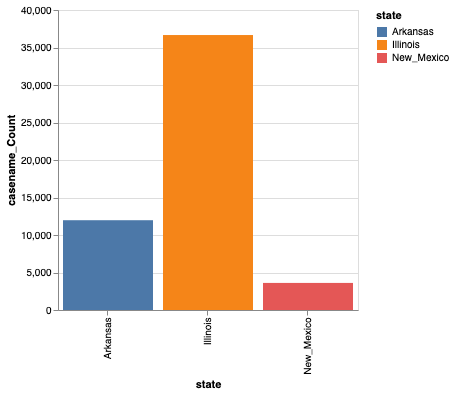

In [5]:
grouped = df.groupby('state').count()
grouped = grouped.add_suffix('_Count').reset_index()

alt.Chart(grouped).mark_bar().encode(
    x='state:N',
    y='casename_Count:Q',
    color='state'
).properties(width=300)

#### 2C. Take a peek at the first few rows in the data

We've taken a look at the *shape* of the data, let's now take a look at the first few rows. 

In [6]:
df.head()

,casename,opinion,state
0,"DANIEL P. YORK, Plaintiff-Appellee, v. GRAND T...",Mr. JUSTICE McGLOON delivered the opinion of t...,Illinois
1,"Marie A. Hesse, Administratrix, Defendant in E...",Mr. Justice Barnes delivered the opinion of th...,Illinois
2,"THE PEOPLE OF THE STATE OF ILLINOIS, Plaintiff...",JUSTICE K1ZZI delivered the opinion of the cou...,Illinois
3,"STATE of New Mexico, Plaintiff-Appellee, v. La...","OPINION SOSA, Senior Justice. Defendant-appell...",New_Mexico
4,"Elva M. Boulter, Appellee, vs. The Joliet Nati...",Mr. Justice Dunn delivered the opinion of the ...,Illinois


#### 2D. Examine the text of one of the opinions in the dataset

And now let's take a look at one of the (copious) opinions in the dataset. In the following line of code, we're asking Python to go to the column called `opinion` in the table and grab the contents of thr 1,234th row (well, if we're being pedanto. 

In [7]:
df['opinion'][0]

'Mr. JUSTICE McGLOON delivered the opinion of the court: Plaintiff Daniel P. York filed suit against his employer, defendant Grand Trunk Western Railroad Company for injuries sustained while working for defendant as a brakeman. Count I was a FELA action brought by plaintiff for injuries he received while attempting to release a handbrake on a caboose. Count II was brought pursuant to FELA and the Federal Safety Appliance and Equipment Act for injuries plaintiff sustained while attempting to uncouple railroad cars. A jury subsequently awarded plaintiff *120,000 for count I and *80,000 for count II. Defendant appealed. On appeal defendant argues that the trial court erred (1) in denying its motion in limine regarding plaintiff’s ability to work as a brakeman; (2) in allowing plaintiff to testify concerning certain statements made by an examining physician; (3) in allowing the jury to award damages for future wage losses; (4) in allowing the jury to award damages for future pain and suffe

#### 2E. Convert the table into a dictionary

To make the data a little bit easier to work with, we're going to take a copy of the data in the DataFrame and structure is as a `dictionary`. Our dictionary is going to use the case name as the key and the text of the opinion(s) as the value. 

In [8]:
cases_dictionary = dict(zip(df['casename'], df['opinion']))

In [9]:
len(cases_dictionary)

51607

## 3. Let's do some natural language processing!

We now have a large portion of the CAP data in memory, but before we start playing with it we're going to zoom out and focus on a single sentence taken from the dataset. Here's the sentence:

> Petitioner Nancy Carlson obtained a judgment for dissolution of marriage, which respondent Charles Carlson moved to vacate on the grounds of unconscionability and duress.

We're going to use a phenomenally useful Python library called spaCy to do the heavy lifting. We've already loaded the model, `general_nlp`, at **1B** above. 

In [10]:
sample_text = """Petitioner Nancy Carlson obtained a judgment for dissolution of marriage, which respondent Charles Carlson moved to vacate on the grounds of unconscionability and duress."""

In [11]:
sample_text

'Petitioner Nancy Carlson obtained a judgment for dissolution of marriage, which respondent Charles Carlson moved to vacate on the grounds of unconscionability and duress.'


---
#### A quick word about documents, sentences and er, words!

Before we jump deeper into this section, it's worth saying a few words about some of the terminology and concepts that are going to come up. 

##### Corpus

The first concept is a **Corpus**. A corpus is simply a collection of *documents*. In the current context, our corpus is the CAP data (i.e. our collection of judgments)

##### Document

The second concept is a **Document**. A document, for our purposes, is a collection of sentences. In the current context, a document is a single judgment.

##### Sentence

The third concept is a **Sentence**. A sentence is a series of words and punctuation marks, *tokens*, arranged in an order that (hopefully) makes grammatical sense. In the current context, our sentence is:

> Petitioner Nancy Carlson obtained a judgment for dissolution of marriage, which respondent Charles Carlson moved to vacate on the grounds of unconscionability and duress.

##### Token

The final concept is the weird one: **Tokens**. A token is a single word or punctuation mark. So **>dissolution of marriage,<** consists of four tokens: `dissolution`, `of`, `marriage` and `,`.

<img src="https://legalhackers19.s3.amazonaws.com/Units_of_text.png">

#### 3A. Apply the model to the sample sentence

First, we apply our the `general_nlp` model to the sample sentence.

In [12]:
doc = general_nlp(sample_text)

In [13]:
doc

Petitioner Nancy Carlson obtained a judgment for dissolution of marriage, which respondent Charles Carlson moved to vacate on the grounds of unconscionability and duress.

#### 3B. Tokenization (or "Tokenisation" on the other side of the Atlantic)



In [14]:
print("{0:<20} {1:>20} ".format("Token", "POS"))
print("-----------------------------------------")
for token in doc:
    print("{0:<20} {1:>20} ".format(token.text, token.pos_))

Token                                 POS 
-----------------------------------------
Petitioner                          PROPN 
Nancy                               PROPN 
Carlson                             PROPN 
obtained                             VERB 
a                                     DET 
judgment                             NOUN 
for                                   ADP 
dissolution                          NOUN 
of                                    ADP 
marriage                             NOUN 
,                                   PUNCT 
which                                 DET 
respondent                           NOUN 
Charles                             PROPN 
Carlson                             PROPN 
moved                                VERB 
to                                   PART 
vacate                               NOUN 
on                                    ADP 
the                                   DET 
grounds                              NOUN 
of          

#### 3B(i) Nouns

In [15]:
print("{0:<20} {1:>20} ".format("Token", "POS"))
print("-----------------------------------------")
for token in doc:
    if token.pos_ == "NOUN":
        print("{0:<20} {1:>20} ".format(token.text, token.pos_))

Token                                 POS 
-----------------------------------------
judgment                             NOUN 
dissolution                          NOUN 
marriage                             NOUN 
respondent                           NOUN 
vacate                               NOUN 
grounds                              NOUN 
unconscionability                    NOUN 
duress                               NOUN 


#### 3B(ii) Verbs

In [16]:
print("{0:<20} {1:>20} ".format("Token", "POS"))
print("-----------------------------------------")
for token in doc:
    if token.pos_ == "VERB":
        print("{0:<20} {1:>20} ".format(token.text, token.pos_))

Token                                 POS 
-----------------------------------------
obtained                             VERB 
moved                                VERB 


#### 3B(iii) Proper Nouns

In [17]:
print("{0:<20} {1:>20} ".format("Token", "POS"))
print("-----------------------------------------")
for token in doc:
    if token.pos_ == "PROPN":
        print("{0:<20} {1:>20} ".format(token.text, token.pos_))

Token                                 POS 
-----------------------------------------
Petitioner                          PROPN 
Nancy                               PROPN 
Carlson                             PROPN 
Charles                             PROPN 
Carlson                             PROPN 


#### 3C. Visualising syntactic dependencies in the sentence

We've taken a look at the individual tokens and inspected their part-of-speech tags. But, it obviously goes without saying that the meaning conveyed by a piece of text is driven by the order and relationships of these tokens when arranged into a larger unit of text, like a sentence. Enter *dependency parsing*.

Dependency parsing is a complex and fine-grained area of study, but it essentially boils down to modelling the relationships between tokens. 

The following line of code takes the sentence we've been working with, 

> Petitioner Nancy Carlson obtained a judgment for dissolution of marriage, which respondent Charles Carlson moved to vacate on the grounds of unconscionability and duress.

... and visualises the relationships between the tokens in the sentence.

In [18]:
displacy.render(doc, jupyter=True, style='dep')

The visualisation above consists of the three main components:

* In the middle, we have the orginal tokens in the sentence (e.g. `Petitioner`, `Nancy`, `Carlson` etc)
* On the bottom row, we have the part-of-speech tag that corresponds to the token (e.g. `PROPN`, `PROPN`, `PROPN` etc)
* At the top we have arcs sweeping left and right from one token to another token

These visualisations take a bit of getting used to, but it becomes a bit clearer when we focus on a smaller chunck of the dependency parse. 

1. We see an arc starting from `Carlson` and pointing back to `Nancy` with a label `compound`. This tells us that the dependency parse has identified the tokens `Nancy` and `Carlson` as a compound of proper nouns, which is correct because `Nancy Carlson` is a compound of a first and last name. 

2. We see an arc starting from `Carlson` (which, as we have seen is part of a compound of proper nouns with `Nancy`) and pointing back to `Petitioner`. This is probably helpful in this context, because Nancy Carlson is the petition in the case. 

3. We see an arc starting from `obtained` and sweeping back to `Carlson` (which, as we have seen in part of a compound of proper nouns that can be used to identify Nancy Carlson as the petitioner in the case). The label on the arc, `nsubj`, tells us that `Petitioner Nancy Carlson` is the noun subject of the verb `obtained`. 

4. What is it that Nancy Carlson obtained? The dependency parse provides the answer here. If trace the arc running from `obtained`, we see that it lands on the noun `judgment` with a label of `dobj`. This tells us the `judgment` is the dependent object of the verb `obtained`. The parse is telling us that Nancy Carlson obtained a judgment. 

Now, clearly we can see that for ourselves simply by reading the first few words in the sentence. But, remember that we're potentially performing an analysis on a corpus of documents that is way too big to for us to read manually. The purpose of the dependency parse is to provide us with the means to programmatically and automatically extract these patterns!



#### 3D. Counting sentences

Another simple metric we can capture is the total number of sentences in an opinion. Sentence detection is one of those things that sounds pretty trivial (surely a sentence is just a string of text starting with a capital letter and ending in `.`, `?` or `!`?), but in practice it can get pretty fiddly, particularly for legal material where the text is peppered with periods that are intended to space out acronyms rather than terminate a sentence.

In [78]:
doc = general_nlp(df['opinion'][1234])

In [20]:
sentences = [sent.text for sent in doc.sents]

In [21]:
len(sentences)

81

## 4. Named-Entity Recognition

We've done a lightning tour of some of the very basic components of natural language processing. We're now going to fast forward on to the fascinating topic of *named entity recognition*. In a nutshell, named entity recognition (NER) is the process of extracting references to real-world things in text. 

Historically, the task of extracting real-world entities from text was exclusively rules-based; we'd decide upfront what sort of things we were interested in extracting and then define rules that could be applied to extract those things. Rules-based methods have their pros and cons. Rules have two major drawbacks. First, we need define a rule for every *thing* we're interested in extracting and this obviously requires us to know what we want to extract upfront. Second, it is extremely difficult to define rules that are context dependent. For example, if we were defining a rule to detect the word `Apple` as a company name rather than the fruit, how would we guard against generating false-positives where the rule encounters the word `Apple` in the context of the fruit? 

Well, we might define our rule to only extract the word `Apple` where the word is capitalised and in many cases that might be perfectly adequate. But what if the author of the text we're processing intended to word `apple` to refer to the makers of the iPhone but didn't capitalise the word (as is often the case in things like tweets)?

Named-entity recognition helps deal with these weird cases by expanding the range of factors that are taken into account when determining whether or not a word or a phrase is conforms to an entity type we're interested in extracting. The named entity recognition models used in the notebook have been trained using multi-layered neural networks (a fancy way of saying "deep learning"). 

### 4A. Let's extract some names!

We're still working with the 1,234th document in the corpus (the one with Nancy Carlson). The following block of code takes the text of the opinion, looks for entities that appear to be people (note, we're only extracting entities labelled `PERSON`) and puts them in a deduped, sorted list.

In [22]:
for ent in doc.ents:
    PERSONS = list(set([ent.text for ent in doc.ents if ent.label_ == 'PERSON']))
    PERSONS.sort()

In [23]:
PERSONS

['Berwyn', 'Charles', 'Charles Carlson', 'Nancy', 'Nancy Carlson', 'Stat']

##### An important aside!

You'll have hopefully noticed that the entity recogniser mainly returned tokens that we would recognise as being the names of people (which was the intention). However, we also got a couple of results back that we probably can't be as confident about. `Berywn` looks like a name (but we can't be sure) and `Stat`, from where we're sitting, looks like the recogniser has returned a false positive. 

These are *predictive models* and they **make mistakes**!

### 4B. Let's extract some date and times!

Same thing as with names, but this time we're just asking the named entity recognition model to give us spans of text labelled as `DATE`.

In [24]:
for ent in doc.ents:
    DATES = list(set([ent.text for ent in doc.ents if ent.label_ == 'DATE']))
    DATES.sort()

In [25]:
DATES

['1983',
 '1987',
 'April of 1985',
 'August 23, 1985',
 'December 1, 1987',
 'December 1, 1987,',
 'February 10',
 'February 10, 1986',
 'January 1986',
 'July 16, 1977',
 'March 31, 1988',
 'May 28, 1985',
 'May 7, 1985',
 'November 10, 1987',
 'September 10',
 'September 10, 1987',
 'September 4',
 'September 4, 1987',
 'September 7',
 'September 7, 1987',
 'just three days',
 'the same day']

### 4C. What about "legal" entities?

So far, we've only looked at general entity types, like names and dates. We'd expect these sort of entities to appear in lots of different types of texts, not just legal texts. 

We'll now switch our attention to the extraction of entities that are *legal* in nature. To do this, we're going to use a model called **Blackstone**, which was developed in London at ICLR's research lab, ICLR&D (https://research.iclr.co.uk).

**Blackstone** is an experimental open-source natural language processing model and pipeline purpose-built for doing NLP on legal texts. It was trained on a large corpus of English case law. The GitHub repo can be found here: https://github.com/ICLRandD/Blackstone

The Nancy Carlson case has served us well, but let's play with a different opinion in the dataset. 

In [145]:
doc = blackstone_nlp(df['opinion'][5678])

Now let's visualise the opinion using Blackstone to highlight the various legal entities it has detected. The visualisation displays the text of the opinion and highlights and labels words and phrases that Blackstone detected (the prototype Blackstone model has been trained to detect case names, citations, legal instruments, provisions, courts and judges). Bear in mind that it was trained on *English* case law and we're applying it to US case law, so the model *will* misfire here and there.

In [146]:
displacy.render(doc, style='ent', options=ner_displacy_options, jupyter=True)

#### 4C(i) Who was the judge?

Let's see if we can find out who delivered this opinion. We're going to assume that the judge delivering the opinion will be the first judge mentioned in the text. 

In [147]:
for ent in doc.ents:
    JUDGES = list(set([ent.text for ent in doc.ents if ent.label_ == 'JUDGE']))
JUDGES[0] # give us the first judge identified

'Mr. Justice Waggoner'

#### 4C(ii) What cases were cited in the opinion?

Now let's see which cases were cited in the opinion.

In [148]:
for ent in doc.ents:
    CASES = list(set([ent.text for ent in doc.ents if ent.label_ == 'CASENAME']))
    CASES.sort()
CASES

['Barber v. People', 'People v. Ham', 'Reifschneider v. Reifschneider']

#### 4C(iii) What legal instruments were cited?

Were any statutes cited?

In [30]:
for ent in doc.ents:
    INSTRUMENTS = list(set([ent.text for ent in doc.ents if ent.label_ == 'INSTRUMENT']))
    INSTRUMENTS.sort()
INSTRUMENTS

['Hurd’s Revised Statute 1917']

#### 4C(iv) What was the case about?

Let's use Blackstone to give us some clues to help us infer what legal topics this case deals with. To do this, we're going to need to first plug in a Blackstone extension, `Concepts()`, which enables us to identify legal concepts mentioned in the text of the opinion. 

In [79]:
if 'Concepts' not in blackstone_nlp.pipe_names:
  concepts_pipe = Concepts(blackstone_nlp) 
  blackstone_nlp.add_pipe(concepts_pipe)

# reapply the model to the opinion

doc = blackstone_nlp(df['opinion'][5678])

In [80]:
doc._.concepts

[('marriage', 10),
 ('abandonment', 2),
 ('indictment', 2),
 ('set aside', 2),
 ('licensing', 1)]

## 4D. Let's go broader and start asking questions of the corpus

So far we've focused on individual opinions, but we can leverage natural language processing to ask broader questions against the corpus itself. 

#### 4D(i) Which judge gave the most opinions in the Illinois data?

Let's find out which judge gave the most opinions in the Illinois data. To make this experiment a bit more portable for the Legal Hacker summit, we're only going to use 500 opinions. 

The following block of code builds a table of 500 Illinois opinions, analyses them and extract the first judge mentioned in each opinion.

In [153]:
illinois_subset_df = df.loc[df['state'] == "Illinois"]
JUDGES_HITS = []

# this is quote slow. To run this cell, make the if statement true

if 1 == 0:

    for casename, opinion, state in zip(illinois_subset_df[:500]['casename'], 
                                        illinois_subset_df[:500]['opinion'], 
                                        illinois_subset_df[:500]['state']):
        doc = blackstone_nlp(opinion)
        JUDGES = [ent.text for ent in doc.ents if ent.label_ == "JUDGE" and "Justice " in ent.text]
        if JUDGES :
            JUDGES_HITS.append(JUDGES[0].lower())    

##### Which judge was the most prolific?

In [152]:
counter = Counter(JUDGES_HITS)
counter.most_common(1)

[('mr. justice barnes', 1)]

##### Give us the top 10 judges

In [ ]:
counter = Counter(JUDGES_HITS)
counter.most_common(10)

##### Visualise the results

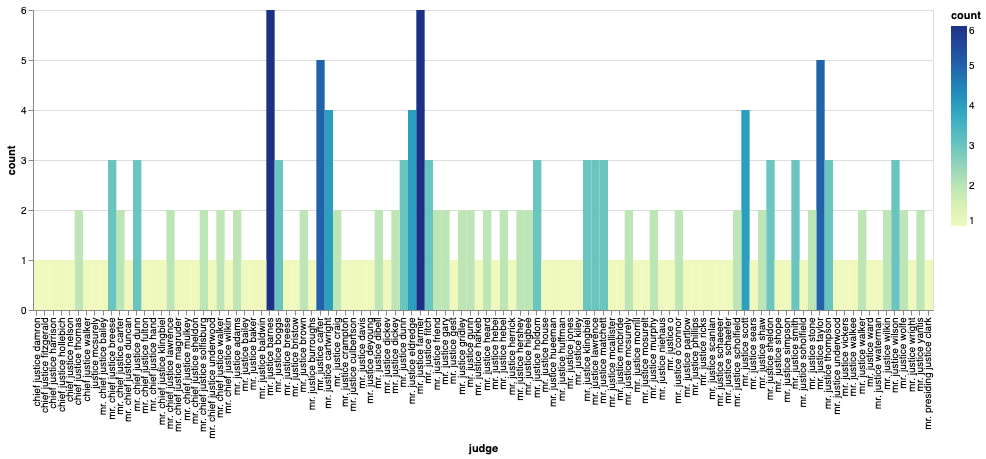

In [ ]:
judge_occurrences = pd.DataFrame.from_dict(counter, orient='index').reset_index()
judge_occurrences = judge_occurrences.rename(columns={'index':'judge', 0:'count'})

alt.Chart(judge_occurrences).mark_rect().encode(
    x='judge:N',
    y=alt.Y(
        ('count:Q'), 
        sort=alt.EncodingSortField(field='count', op='sum', order='descending')),
    color='count:Q',
    tooltip=['judge']
).interactive().properties(width=900)


## 5. Assessing "significance"

We can use our knowledge of natural language processing to begin to answer deeper and more complex questions about the data. One of the projects we've been working on at ICLR&D is whether we can develop techniques that can be used to automatically determine whether or not an opinion is *significant* in the sense that it:

* Creates new law
* Modifies existing law
* Explains or clarifies existing law

To do this, we analysed a large number of reported and unreported English opinions. In our analysis, a *reported* opinion represents an example of an opinion that exhibits at least one of the three qualities listed above. Conversely, an unreported opinion represents an example of an opinion that does not exhibit one of those three qualities. 

Once we had enough examples of each sort of opinion, we used natural language processing techniques to extract a range of metrics about the cases, which included things like:

* How many tokens were in the opinion?
* How many cases were cited?
* How many entities were present?
* What was the ratio of entities to non-entity tokens?
* How many sentences in the opinion expressed a conclusion or included a reference to a legal test?

With these metrics, we were able to model some of the qualities that *significant* cases tend to exhibit. We applied that model to a subset of the CAP data consisting of about 2,100 randomly selected opinions (which obviously weren't included in the training of our significance model). 

Here's what we found. 

### Very few cases in the subset were assessed as "significant"

Of the 2,100 or so cases analysed, only about 5% were assessed by the model as being significant from a predential point of view.

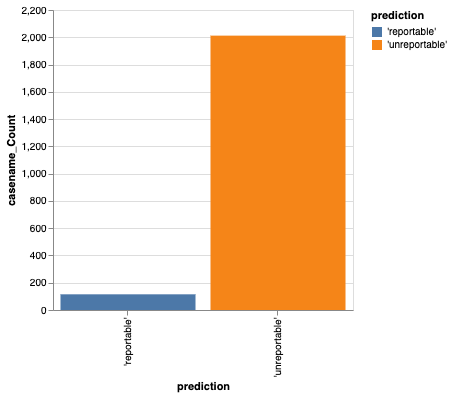

In [217]:
ark_reportability_data = pd.read_csv('cap_nova_predictions_ark.csv')
grouped = ark_reportability_data.groupby('prediction').count()
grouped = grouped.add_suffix('_Count').reset_index()

alt.Chart(grouped).mark_bar().encode(
    x='prediction',
    y='casename_Count:Q',
    color='prediction', 
    tooltip=['casename_Count:Q']
).interactive().properties(width=300)

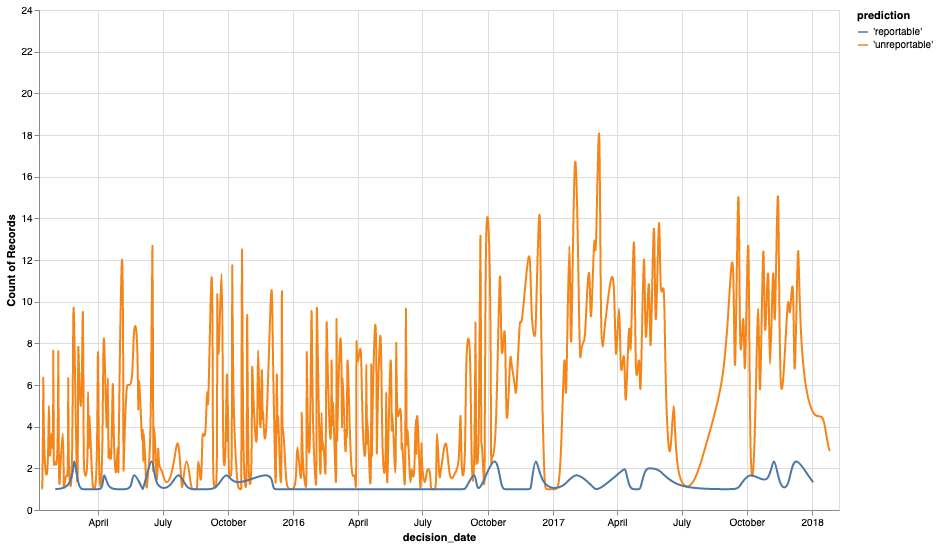

In [220]:
alt.Chart(ark_reportability_data).mark_line(interpolate='basis-open').encode(
    x='decision_date:T',
    y='count(casename):Q',
    color='prediction:N',
    tooltip=['prediction:N', 'decision_date:T', 'jurisdiction:N']
).interactive().properties(height=500, width=800)

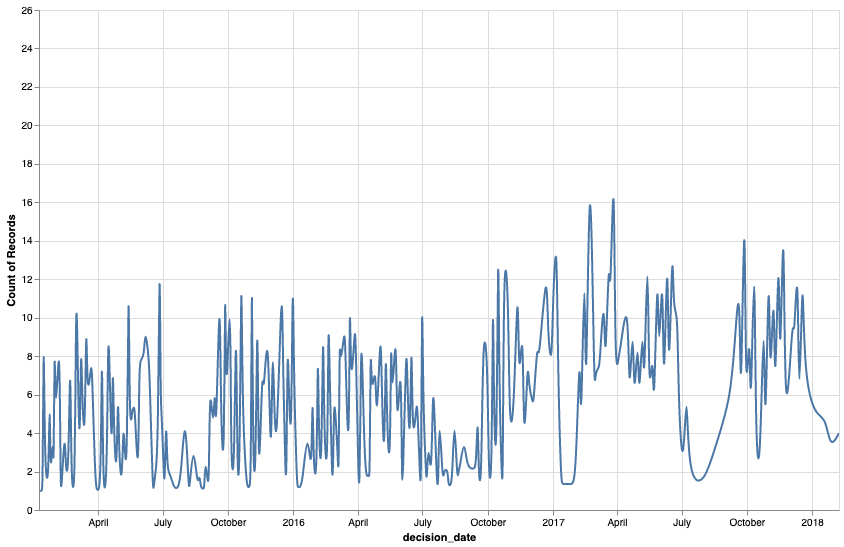

In [223]:
alt.Chart(ark_reportability_data).mark_line(interpolate='bundle').encode(
    x='decision_date:T',
    y='count(decision_date):Q',
    tooltip=['count(decision_date):Q']
).interactive().properties(height=500, width=800)